# Toy Problem 2

In [1]:
#necessary imports

import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern

from ipywidgets import interact

### Helper Functions

In [2]:
def plot_data(x, y, x_agg, y_agg, x_test, y_pred=None, aleatoric_uncertainty=None, epistemic_uncertainty=None, total_uncertainty=None, title=None):
    if y_pred is not None:
        
        df = pd.DataFrame({'x': x, 'y': y})

        fig, ax = plt.subplots(3,1, figsize=(10, 5.5), dpi=300, sharex=True, gridspec_kw={'height_ratios': [2, 1.5, 1.5]})
        fig.suptitle(title, fontsize=12)
        
        #subspaces
        ax[0].fill_betweenx([0,1.2], 0, 10, color='grey', alpha=0.1)
        ax[0].fill_betweenx([0,1.2], 10, 20, color='grey', alpha=0.2)
        ax[0].fill_betweenx([0,1.2], 20, 30, color='grey', alpha=0.1)
        ax[0].fill_betweenx([0,1.2], 30, 40, color='grey', alpha=0.2)
        ax[0].fill_betweenx([0,1.2], 40, 50, color='grey', alpha=0.1)
        ax[0].fill_betweenx([0,1.2], 50, 60, color='grey', alpha=0.2)
        ax[0].fill_betweenx([0,1.2], 60, 70, color='grey', alpha=0.1)
        ax[0].fill_betweenx([0,1.2], 70, 80, color='grey', alpha=0.2)
        ax[0].fill_betweenx([0,1.2], 80, 90, color='grey', alpha=0.1)
        ax[0].fill_betweenx([0,1.2], 90, 100, color='grey', alpha=0.2)

        #ground truth
        ax[0].plot(np.arange(10,21,1), [0.7]*11, color='blue', label='ground truth', linewidth=1.5)
        ax[0].plot(np.arange(20,31,1), [0.75]*11, color='blue', linewidth=1.5)
        ax[0].plot(np.arange(30,41,1), [0.85]*11, color='blue', linewidth=1.5)
        ax[0].plot(np.arange(40,51,1), [0.6]*11, color='blue', linewidth=1.5)
        ax[0].plot(np.arange(50,61,1), [0.8]*11, color='blue', linewidth=1.5)
        ax[0].plot(np.arange(60,71,1), [0.9]*11, color='blue', linewidth=1.5)
        ax[0].plot(np.arange(70,81,1), [0.85]*11, color='blue', linewidth=1.5)
        ax[0].plot(np.arange(80,91,1), [0.85]*11, color='blue', linewidth=1.5)

        ax[0].fill_between(np.arange(10,21,1), [0.7-1.96*np.sqrt(0.0001)]*11, [0.7+1.96*np.sqrt(0.0001)]*11, color='blue', alpha=0.2, label='95% PI - ground truth')
        ax[0].fill_between(np.arange(20,31,1), [0.75-1.96*np.sqrt(0.0009)]*11, [0.75+1.96*np.sqrt(0.0009)]*11, color='blue', alpha=0.2)
        ax[0].fill_between(np.arange(30,41,1), [0.85-1.96*np.sqrt(0.0009)]*11, [0.85+1.96*np.sqrt(0.0009)]*11, color='blue', alpha=0.2)
        ax[0].fill_between(np.arange(40,51,1), [0.6-1.96*np.sqrt(0.0064)]*11, [0.6+1.96*np.sqrt(0.0064)]*11, color='blue', alpha=0.2)
        ax[0].fill_between(np.arange(50,61,1), [0.8-1.96*np.sqrt(0.0036)]*11, [0.8+1.96*np.sqrt(0.0036)]*11, color='blue', alpha=0.2)
        ax[0].fill_between(np.arange(60,71,1), [0.9-1.96*np.sqrt(0.0016)]*11, [0.9+1.96*np.sqrt(0.0016)]*11, color='blue', alpha=0.2)
        ax[0].fill_between(np.arange(70,81,1), [0.85-1.96*np.sqrt(0.0016)]*11, [0.85+1.96*np.sqrt(0.0016)]*11, color='blue', alpha=0.2)
        ax[0].fill_between(np.arange(80,91,1), [0.85-1.96*np.sqrt(0.0004)]*11, [0.85+1.96*np.sqrt(0.0004)]*11, color='blue', alpha=0.2)

        #observations
        ax[0].scatter([],[], color='black', label='observations')
        sns.boxplot(x='x', y='y', data=df, fliersize=0.1,native_scale=True, ax=ax[0], linewidth=1.5, label='observed distribution')
        sns.stripplot(x='x', y='y', data=df, color='black', jitter=True, alpha=0.5, size=2, native_scale=True, ax=ax[0], linewidth=1.5)

        #predictions
        ax[0].plot(x_test, y_pred, color='red', label='prediction', linewidth=1.5)
        ax[0].fill_between(x_test, y_pred - 1.96 * np.sqrt(total_uncertainty), y_pred + 1.96 * np.sqrt(total_uncertainty), color='red', alpha=0.2, label='95% PI - total predicted uncertainty')

        ax[0].set_ylabel('acc')
        ax[0].set_ylim([0,1])
        ax[0].yaxis.grid(True)

        ax[0].legend(loc='lower right')

        #subspaces
        ax[1].fill_betweenx([0,0.018], 0, 10, color='grey', alpha=0.1)
        ax[1].fill_betweenx([0,0.018], 10, 20, color='grey', alpha=0.2)
        ax[1].fill_betweenx([0,0.018], 20, 30, color='grey', alpha=0.1)
        ax[1].fill_betweenx([0,0.018], 30, 40, color='grey', alpha=0.2)
        ax[1].fill_betweenx([0,0.018], 40, 50, color='grey', alpha=0.1)
        ax[1].fill_betweenx([0,0.018], 50, 60, color='grey', alpha=0.2)
        ax[1].fill_betweenx([0,0.018], 60, 70, color='grey', alpha=0.1)
        ax[1].fill_betweenx([0,0.018], 70, 80, color='grey', alpha=0.2)
        ax[1].fill_betweenx([0,0.018], 80, 90, color='grey', alpha=0.1)
        ax[1].fill_betweenx([0,0.018], 90, 100, color='grey', alpha=0.2)

        #ground truth
        ax[1].plot(np.arange(10,21,1), [0.0001]*11, color='darkcyan', label='ground truth', linewidth=1.5)
        ax[1].plot(np.arange(20,31,1), [0.0009]*11, color='darkcyan', linewidth=1.5)
        ax[1].plot(np.arange(30,41,1), [0.0009]*11, color='darkcyan', linewidth=1.5)
        ax[1].plot(np.arange(40,51,1), [0.0064]*11, color='darkcyan', linewidth=1.5)
        ax[1].plot(np.arange(50,61,1), [0.0036]*11, color='darkcyan', linewidth=1.5)
        ax[1].plot(np.arange(60,71,1), [0.0016]*11, color='darkcyan', linewidth=1.5)
        ax[1].plot(np.arange(70,81,1), [0.0016]*11, color='darkcyan', linewidth=1.5)
        ax[1].plot(np.arange(80,91,1), [0.0004]*11, color='darkcyan', linewidth=1.5)


        #observations
        ax[1].bar(x_agg, y_agg[:,1], color='black', label='observation')

        #predictions
        ax[1].plot(x_test, aleatoric_uncertainty, color='orange', label='prediction', linewidth=1.5)
        
        
        ax[1].set_ylabel('var')
        ax[1].set_ylim([0,0.018])
        ax[1].yaxis.grid(True)

        ax[1].legend(loc='upper right')

        #subspaces
        ax[2].fill_betweenx([0,0.018], 0, 10, color='grey', alpha=0.1)
        ax[2].fill_betweenx([0,0.018], 10, 20, color='grey', alpha=0.2)
        ax[2].fill_betweenx([0,0.018], 20, 30, color='grey', alpha=0.1)
        ax[2].fill_betweenx([0,0.018], 30, 40, color='grey', alpha=0.2)
        ax[2].fill_betweenx([0,0.018], 40, 50, color='grey', alpha=0.1)
        ax[2].fill_betweenx([0,0.018], 50, 60, color='grey', alpha=0.2)
        ax[2].fill_betweenx([0,0.018], 60, 70, color='grey', alpha=0.1)
        ax[2].fill_betweenx([0,0.018], 70, 80, color='grey', alpha=0.2)
        ax[2].fill_betweenx([0,0.018], 80, 90, color='grey', alpha=0.1)
        ax[2].fill_betweenx([0,0.018], 90, 100, color='grey', alpha=0.2)

        #predictions
        ax[2].plot(x_test, epistemic_uncertainty, color='green', label='prediction', linewidth=1.5)
        
        ax[2].set_ylabel('var')
        ax[2].set_ylim([0,0.018])
        ax[2].yaxis.grid(True)

        ax[2].legend(loc='upper right')

        #subplot to zoom in on a specific region of the plot
        # if title == 'CatBoost':
        #     # inset Axes....
        #     x1, x2, y1, y2 = 35, 55, 0, 1e-5  # subregion of the original image
        #     axins = ax[2].inset_axes(
        #         [0.2, 0.2, 0.5, 0.5],
        #         xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
        #     axins.plot(x_test[35:55], epistemic_uncertainty[35:55], color='green', label='Epistemic', linewidth=2)
        #     axins.set_ylim([0,1e-4])
        #     axins.set_yticks([0, 5e-5, 1e-4])
        #     axins.set_yticklabels(['0', '5e-5', '1e-4'])

        #     ax[2].indicate_inset_zoom(axins, edgecolor="black")

        ax[2].set_xlabel('meta-feature 1')
        ax[2].set_xlim([np.min(x_test), np.max(x_test)])

        ax[2].set_xticks(np.arange(np.min(x_test),np.max(x_test),10))

        #plt.savefig(f"toy2_{title}.pdf", format="pdf", bbox_inches="tight")
        

    else:
        df = pd.DataFrame({'x': x, 'y': y})

        fig, ax = plt.subplots(figsize=(10, 4), dpi=300)
        fig.suptitle('Problem setup', fontsize=12)

        #subspaces
        ax.fill_betweenx([0,1], 0, 10, color='grey', alpha=0.1)
        ax.fill_betweenx([0,1], 10, 20, color='grey', alpha=0.2)
        ax.fill_betweenx([0,1], 20, 30, color='grey', alpha=0.1)
        ax.fill_betweenx([0,1], 30, 40, color='grey', alpha=0.2)
        ax.fill_betweenx([0,1], 40, 50, color='grey', alpha=0.1)
        ax.fill_betweenx([0,1], 50, 60, color='grey', alpha=0.2)
        ax.fill_betweenx([0,1], 60, 70, color='grey', alpha=0.1)
        ax.fill_betweenx([0,1], 70, 80, color='grey', alpha=0.2)
        ax.fill_betweenx([0,1], 80, 90, color='grey', alpha=0.1)
        ax.fill_betweenx([0,1], 90, 100, color='grey', alpha=0.2)

        #ground truth
        ax.plot(np.arange(10,21,1), [0.7]*11, color='blue', label='ground truth', linewidth=1.5)
        ax.plot(np.arange(20,31,1), [0.75]*11, color='blue', linewidth=1.5)
        ax.plot(np.arange(30,41,1), [0.85]*11, color='blue', linewidth=1.5)
        ax.plot(np.arange(40,51,1), [0.6]*11, color='blue', linewidth=1.5)
        ax.plot(np.arange(50,61,1), [0.8]*11, color='blue', linewidth=1.5)
        ax.plot(np.arange(60,71,1), [0.9]*11, color='blue', linewidth=1.5)
        ax.plot(np.arange(70,81,1), [0.85]*11, color='blue', linewidth=1.5)
        ax.plot(np.arange(80,91,1), [0.85]*11, color='blue', linewidth=1.5)

        ax.fill_between(np.arange(10,21,1), [0.7-1.96*np.sqrt(0.0001)]*11, [0.7+1.96*np.sqrt(0.0001)]*11, color='blue', alpha=0.2, label='95% PI - ground truth')
        ax.fill_between(np.arange(20,31,1), [0.75-1.96*np.sqrt(0.0009)]*11, [0.75+1.96*np.sqrt(0.0009)]*11, color='blue', alpha=0.2)
        ax.fill_between(np.arange(30,41,1), [0.85-1.96*np.sqrt(0.0009)]*11, [0.85+1.96*np.sqrt(0.0009)]*11, color='blue', alpha=0.2)
        ax.fill_between(np.arange(40,51,1), [0.6-1.96*np.sqrt(0.0064)]*11, [0.6+1.96*np.sqrt(0.0064)]*11, color='blue', alpha=0.2)
        ax.fill_between(np.arange(50,61,1), [0.8-1.96*np.sqrt(0.0036)]*11, [0.8+1.96*np.sqrt(0.0036)]*11, color='blue', alpha=0.2)
        ax.fill_between(np.arange(60,71,1), [0.9-1.96*np.sqrt(0.0016)]*11, [0.9+1.96*np.sqrt(0.0016)]*11, color='blue', alpha=0.2)
        ax.fill_between(np.arange(70,81,1), [0.85-1.96*np.sqrt(0.0016)]*11, [0.85+1.96*np.sqrt(0.0016)]*11, color='blue', alpha=0.2)
        ax.fill_between(np.arange(80,91,1), [0.85-1.96*np.sqrt(0.0004)]*11, [0.85+1.96*np.sqrt(0.0004)]*11, color='blue', alpha=0.2)
        
        #observations
        ax.scatter([],[], color='black', label='observations')
        sns.boxplot(x='x', y='y', data=df, fliersize=0.1,native_scale=True, ax=ax, label='observed distribution')
        sns.stripplot(x='x', y='y', data=df, color='black', alpha=0.5, size=2, native_scale=True, ax=ax)

        ax.set_xlabel('meta-feature 1', fontsize=12)
        ax.set_ylabel('acc', fontsize=12)

        ax.set_xlim([np.min(x_test), np.max(x_test)])
        ax.set_ylim([0,1])

        ax.set_xticks(np.arange(np.min(x_test),np.max(x_test)+1,10))
        ax.yaxis.grid(True)

        ax.legend(loc='lower right')

        #plt.savefig("general_setup.pdf", format="pdf", bbox_inches="tight")

    plt.tight_layout

    plt.show()

In [3]:
def plot_all(x, y, x_agg, y_agg, x_test, 
             y_pred_rf=None, aleatoric_uncertainty_rf=None, epistemic_uncertainty_rf=None, total_uncertainty_rf=None,
             y_pred_cb=None, aleatoric_uncertainty_cb=None, epistemic_uncertainty_cb=None, total_uncertainty_cb=None, 
             y_pred_gpr=None, aleatoric_uncertainty_gpr=None, epistemic_uncertainty_gpr=None, total_uncertainty_gpr=None):
    
    if y_pred_gpr is not None:
        df = pd.DataFrame({'x': x, 'y': y})

        fig, ax = plt.subplots(3,3, figsize=(10, 5.5),dpi=300, sharex=True, gridspec_kw={'height_ratios': [1.5, 1, 1]})

        for i in range(3):
            
            #subspaces
            ax[0,i].fill_betweenx([0,1.2], 0, 10, color='grey', alpha=0.1)
            ax[0,i].fill_betweenx([0,1.2], 10, 20, color='grey', alpha=0.2)
            ax[0,i].fill_betweenx([0,1.2], 20, 30, color='grey', alpha=0.1)
            ax[0,i].fill_betweenx([0,1.2], 30, 40, color='grey', alpha=0.2)
            ax[0,i].fill_betweenx([0,1.2], 40, 50, color='grey', alpha=0.1)
            ax[0,i].fill_betweenx([0,1.2], 50, 60, color='grey', alpha=0.2)
            ax[0,i].fill_betweenx([0,1.2], 60, 70, color='grey', alpha=0.1)
            ax[0,i].fill_betweenx([0,1.2], 70, 80, color='grey', alpha=0.2)
            ax[0,i].fill_betweenx([0,1.2], 80, 90, color='grey', alpha=0.1)
            ax[0,i].fill_betweenx([0,1.2], 90, 100, color='grey', alpha=0.2)

            #ground truth
        
            ax[0,i].plot(np.arange(10,21,1), [0.7]*11, color='blue', linewidth=1.5)
            ax[0,i].plot(np.arange(20,31,1), [0.75]*11, color='blue', linewidth=1.5)
            ax[0,i].plot(np.arange(30,41,1), [0.85]*11, color='blue', linewidth=1.5)
            ax[0,i].plot(np.arange(40,51,1), [0.6]*11, color='blue', linewidth=1.5)
            ax[0,i].plot(np.arange(50,61,1), [0.8]*11, color='blue', linewidth=1.5)
            ax[0,i].plot(np.arange(60,71,1), [0.9]*11, color='blue', linewidth=1.5)
            ax[0,i].plot(np.arange(70,81,1), [0.85]*11, color='blue', linewidth=1.5)
            ax[0,i].plot(np.arange(80,91,1), [0.85]*11, color='blue', linewidth=1.5)

            ax[0,i].fill_between(np.arange(10,21,1), [0.7-1.96*np.sqrt(0.0001)]*11, [0.7+1.96*np.sqrt(0.0001)]*11, color='blue', alpha=0.2)
            ax[0,i].fill_between(np.arange(20,31,1), [0.75-1.96*np.sqrt(0.0009)]*11, [0.75+1.96*np.sqrt(0.0009)]*11, color='blue', alpha=0.2)
            ax[0,i].fill_between(np.arange(30,41,1), [0.85-1.96*np.sqrt(0.0009)]*11, [0.85+1.96*np.sqrt(0.0009)]*11, color='blue', alpha=0.2)
            ax[0,i].fill_between(np.arange(40,51,1), [0.6-1.96*np.sqrt(0.0064)]*11, [0.6+1.96*np.sqrt(0.0064)]*11, color='blue', alpha=0.2)
            ax[0,i].fill_between(np.arange(50,61,1), [0.8-1.96*np.sqrt(0.0036)]*11, [0.8+1.96*np.sqrt(0.0036)]*11, color='blue', alpha=0.2)
            ax[0,i].fill_between(np.arange(60,71,1), [0.9-1.96*np.sqrt(0.0016)]*11, [0.9+1.96*np.sqrt(0.0016)]*11, color='blue', alpha=0.2)
            ax[0,i].fill_between(np.arange(70,81,1), [0.85-1.96*np.sqrt(0.0016)]*11, [0.85+1.96*np.sqrt(0.0016)]*11, color='blue', alpha=0.2)
            ax[0,i].fill_between(np.arange(80,91,1), [0.85-1.96*np.sqrt(0.0004)]*11, [0.85+1.96*np.sqrt(0.0004)]*11, color='blue', alpha=0.2)

            #observations
            sns.boxplot(x='x', y='y', data=df, fliersize=0.1,native_scale=True, ax=ax[0,i], linewidth=1.5)
            sns.stripplot(x='x', y='y', data=df, color='black', jitter=True, alpha=0.5, size=2, native_scale=True, ax=ax[0,i], linewidth=1.5)
          
        #labels for legend
        ax[0,2].plot([], [], color='blue', label='ground truth', linewidth=1.5)
        ax[0,2].fill_between([],[], [], color='blue', alpha=0.2, label='95% PI - ground truth')
        ax[0,2].scatter([],[], color='black', label='observations')
        ax[0,2].fill_between([], [], [], color='steelblue', label='observed distribution', linewidth=1.5)
        
        #predictions
        ax[0,0].plot(x_test, y_pred_rf, color='red', linewidth=1.5)
        ax[0,0].fill_between(x_test, y_pred_rf - 1.96 * np.sqrt(total_uncertainty_rf), y_pred_rf + 1.96 * np.sqrt(total_uncertainty_rf), color='red', alpha=0.2)

        ax[0,1].plot(x_test, y_pred_cb, color='red', linewidth=1.5)
        ax[0,1].fill_between(x_test, y_pred_cb - 1.96 * np.sqrt(total_uncertainty_cb), y_pred_gpr + 1.96 * np.sqrt(total_uncertainty_cb), color='red', alpha=0.2)

        ax[0,2].plot(x_test, y_pred_gpr, color='red', label='prediction', linewidth=1.5)
        ax[0,2].fill_between(x_test, y_pred_gpr - 1.96 * np.sqrt(total_uncertainty_gpr), y_pred_gpr + 1.96 * np.sqrt(total_uncertainty_gpr), color='red', alpha=0.2, label='95% PI - total predicted uncertainty')

        ax[0,0].set_ylabel('acc', fontsize=12)
        ax[0,1].set(ylabel=None)
        ax[0,2].set(ylabel=None)
        ax[0,0].set_ylim([0,1])
        ax[0,1].set_ylim([0,1])
        ax[0,2].set_ylim([0,1])
        ax[0,0].yaxis.grid(True)
        ax[0,1].yaxis.grid(True)
        ax[0,2].yaxis.grid(True)
        ax[0,1].tick_params('y', left=False, labelleft=False)
        ax[0,2].tick_params('y', left=False, labelleft=False)

        #labels for legend
        ax[0,2].plot([],[], color='darkcyan', label='ground truth aleatoric',linewidth=1.5)
        ax[0,2].scatter([], [], color='black', label='observation aleatoric', linewidth=1.5, marker='s')
        ax[0,2].plot([], [], color='orange', label='prediction aleatoric', linewidth=1.5)
        ax[0,2].plot([], [], color='green', label='prediction epistemic', linewidth=1.5)

        for i in range(3):
            #subspaces

            ax[1,i].fill_betweenx([0,0.018], 0, 10, color='grey', alpha=0.1)
            ax[1,i].fill_betweenx([0,0.018], 10, 20, color='grey', alpha=0.2)
            ax[1,i].fill_betweenx([0,0.018], 20, 30, color='grey', alpha=0.1)
            ax[1,i].fill_betweenx([0,0.018], 30, 40, color='grey', alpha=0.2)
            ax[1,i].fill_betweenx([0,0.018], 40, 50, color='grey', alpha=0.1)
            ax[1,i].fill_betweenx([0,0.018], 50, 60, color='grey', alpha=0.2)
            ax[1,i].fill_betweenx([0,0.018], 60, 70, color='grey', alpha=0.1)
            ax[1,i].fill_betweenx([0,0.018], 70, 80, color='grey', alpha=0.2)
            ax[1,i].fill_betweenx([0,0.018], 80, 90, color='grey', alpha=0.1)
            ax[1,i].fill_betweenx([0,0.018], 90, 100, color='grey', alpha=0.2)

            #ground truth

            ax[1,i].plot(np.arange(10,21,1), [0.0001]*11, color='darkcyan', linewidth=1.5)
            ax[1,i].plot(np.arange(20,31,1), [0.0009]*11, color='darkcyan', linewidth=1.5)
            ax[1,i].plot(np.arange(30,41,1), [0.0009]*11, color='darkcyan', linewidth=1.5)
            ax[1,i].plot(np.arange(40,51,1), [0.0064]*11, color='darkcyan', linewidth=1.5)
            ax[1,i].plot(np.arange(50,61,1), [0.0036]*11, color='darkcyan', linewidth=1.5)
            ax[1,i].plot(np.arange(60,71,1), [0.0016]*11, color='darkcyan', linewidth=1.5)
            ax[1,i].plot(np.arange(70,81,1), [0.0016]*11, color='darkcyan', linewidth=1.5)
            ax[1,i].plot(np.arange(80,91,1), [0.0004]*11, color='darkcyan', linewidth=1.5)


            #observations
            ax[1,i].bar(x_agg, y_agg[:,1], color='black', label='observation', linewidth=1.5)

        #predictions
        ax[1,0].plot(x_test, aleatoric_uncertainty_rf, color='orange', label='prediction', linewidth=1.5)
        ax[1,1].plot(x_test, aleatoric_uncertainty_cb, color='orange', label='prediction', linewidth=1.5)
        ax[1,2].plot(x_test, aleatoric_uncertainty_gpr, color='orange', label='prediction', linewidth=1.5)
        
        ax[1,0].set_ylabel('var', fontsize=12)
        ax[1,1].set(ylabel=None)
        ax[1,2].set(ylabel=None)
        ax[1,0].set_ylim([0,0.018])
        ax[1,1].set_ylim([0,0.018])
        ax[1,2].set_ylim([0,0.018])
        ax[1,0].yaxis.grid(True)
        ax[1,1].yaxis.grid(True)
        ax[1,2].yaxis.grid(True)
        ax[1,1].tick_params('y', left=False, labelleft=False)
        ax[1,2].tick_params('y', left=False, labelleft=False)

        for i in range(3):

            #subspaces
            ax[2,i].fill_betweenx([0,0.018], 0, 10, color='grey', alpha=0.1)
            ax[2,i].fill_betweenx([0,0.018], 10, 20, color='grey', alpha=0.2)
            ax[2,i].fill_betweenx([0,0.018], 20, 30, color='grey', alpha=0.1)
            ax[2,i].fill_betweenx([0,0.018], 30, 40, color='grey', alpha=0.2)
            ax[2,i].fill_betweenx([0,0.018], 40, 50, color='grey', alpha=0.1)
            ax[2,i].fill_betweenx([0,0.018], 50, 60, color='grey', alpha=0.2)
            ax[2,i].fill_betweenx([0,0.018], 60, 70, color='grey', alpha=0.1)
            ax[2,i].fill_betweenx([0,0.018], 70, 80, color='grey', alpha=0.2)
            ax[2,i].fill_betweenx([0,0.018], 80, 90, color='grey', alpha=0.1)
            ax[2,i].fill_betweenx([0,0.018], 90, 100, color='grey', alpha=0.2)

        ax[2,0].plot(x_test, epistemic_uncertainty_rf, color='green', label='prediction', linewidth=1.5)
        ax[2,1].plot(x_test, epistemic_uncertainty_cb, color='green', label='prediction', linewidth=1.5)
        ax[2,2].plot(x_test, epistemic_uncertainty_gpr, color='green', label='prediction', linewidth=1.5)
        
        ax[2,0].set_ylabel('var', fontsize=12)
        ax[2,1].set(ylabel=None)
        ax[2,2].set(ylabel=None)
        ax[2,0].set_ylim([0,0.018])
        ax[2,1].set_ylim([0,0.018])
        ax[2,2].set_ylim([0,0.018])
        ax[2,0].yaxis.grid(True)
        ax[2,1].yaxis.grid(True)
        ax[2,2].yaxis.grid(True)
        ax[2,1].tick_params('y', left=False, labelleft=False)
        ax[2,2].tick_params('y', left=False, labelleft=False)

        #zoom in on a specific region of the plot
        x1, x2, y1, y2 = 35, 55, 0, 1e-5  # subregion of the original image
        axins = ax[2,1].inset_axes(
             [0.2, 0.2, 0.5, 0.5],
                 xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
        axins.plot(x_test[35:55], epistemic_uncertainty_cb[35:55], color='green', label='Epistemic', linewidth=2)
        axins.set_ylim([0,1e-4])
        axins.set_yticks([0, 5e-5, 1e-4])
        axins.set_yticklabels(['0', '5e-5', '1e-4'])
        axins.fill_betweenx([0,1e-4], 35, 40, color='grey', alpha=0.2)
        axins.fill_betweenx([0,1e-4], 40, 50, color='grey', alpha=0.1)
        axins.fill_betweenx([0,1e-4], 50, 55, color='grey', alpha=0.2)
        ax[2,1].indicate_inset_zoom(axins, edgecolor="black")

        ax[2,0].set_xlabel('meta-feature 1')
        ax[2,1].set_xlabel('meta-feature 1')
        ax[2,2].set_xlabel('meta-feature 1')
        ax[2,0].set_xlim([np.min(x_test), np.max(x_test)])
        ax[2,1].set_xlim([np.min(x_test), np.max(x_test)])
        ax[2,2].set_xlim([np.min(x_test), np.max(x_test)])

        ax[2,0].set_xticks(np.arange(np.min(x_test),np.max(x_test)+1,10))
        ax[2,1].set_xticks(np.arange(np.min(x_test),np.max(x_test)+1,10))
        ax[2,2].set_xticks(np.arange(np.min(x_test),np.max(x_test)+1,10))

        ax[0,0].set_title('total uncertainty', fontsize=12, loc='left')
        ax[1,0].set_title('aleatoric uncertainty', fontsize=12, loc='left')
        ax[2,0].set_title('epistemic uncertainty', fontsize=12, loc='left')    
    
        handles, labels = ax[0, 2].get_legend_handles_labels()  
        fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.15)) 

        ax[0,0].annotate('RF', xy=(0.47, 1.2), xycoords='axes fraction', fontsize=12)
        ax[0,1].annotate('vSGLB', xy=(0.4, 1.2), xycoords='axes fraction', fontsize=12)
        ax[0,2].annotate('GPR', xy=(0.43, 1.2), xycoords='axes fraction', fontsize=12)

    #plt.savefig("toy2_all.pdf", format="pdf", bbox_inches="tight")

    plt.tight_layout()
    plt.show()

In [4]:
def train_rf(x_agg, y_agg, x_test_qual):
    #model and training
    rf = RandomForestRegressor(random_state=0)
    rf.fit(x_agg.reshape(-1,1), y_agg)

    #predictions to calculate uncertainties
    y_pred_mean_rf_help = np.empty([rf.n_estimators, x_test_qual.shape[0]])
    y_pred_var_rf_help = np.empty([rf.n_estimators, x_test_qual.shape[0]])
    for i in range(rf.n_estimators):
        y_pred_rf_help = rf.estimators_[i].predict(x_test_qual.reshape(-1,1))
        y_pred_mean_rf_help[i] = y_pred_rf_help[:,0]
        y_pred_var_rf_help[i] = y_pred_rf_help[:,1]

    #mean prediction
    y_pred_mean_rf = np.mean(y_pred_mean_rf_help, axis=0)

    #uncertainties (var)
    aleatoric_uncertainty_rf = np.mean(y_pred_var_rf_help, axis=0)
    epistemic_uncertainty_rf = np.var(y_pred_mean_rf_help, axis=0)
    total_uncertainty_rf = aleatoric_uncertainty_rf + epistemic_uncertainty_rf

    return y_pred_mean_rf, aleatoric_uncertainty_rf, epistemic_uncertainty_rf, total_uncertainty_rf

In [5]:
def train_cb(x, y, x_test_qual):
    #model and training
    cbr = CatBoostRegressor(loss_function='RMSEWithUncertainty', verbose=False,
                                            bootstrap_type='Bernoulli', custom_metric='RMSE',
                                            posterior_sampling=True, n_estimators=100, random_seed=0)
    cbr.fit(x.reshape(-1,1), y)

    #predictions to calculate uncertainties
    pred_cbr_help = cbr.virtual_ensembles_predict(x_test_qual.reshape(-1,1), virtual_ensembles_count=10, prediction_type='TotalUncertainty')

    #mean prediction
    y_pred_mean_cbr = pred_cbr_help[:,0] 

    #uncertainties
    epistemic_uncertainty_cbr = pred_cbr_help[:,1]
    aleatoric_uncertainty_cbr = pred_cbr_help[:,2]
    total_uncertainty_cbr = epistemic_uncertainty_cbr + aleatoric_uncertainty_cbr

    return y_pred_mean_cbr, aleatoric_uncertainty_cbr, epistemic_uncertainty_cbr, total_uncertainty_cbr

In [6]:
def train_gpr(x_agg, y_agg, x_test_qual):
    #model and training
    gpr_mean = GaussianProcessRegressor(Matern(), normalize_y=True, alpha=y_agg[:,1])
    gpr_var = GaussianProcessRegressor()
    gpr_mean.fit(x_agg.reshape(-1,1), y_agg[:,0])
    gpr_var.fit(x_agg.reshape(-1,1), y_agg[:,1])

    #predictions to calculate uncertainties
    y_pred_mean_gpr, y_pred_epistemic_gpr = gpr_mean.predict(x_test_qual.reshape(-1,1), return_std=True)
    y_pred_var_gpr = gpr_var.predict(x_test_qual.reshape(-1,1), return_std=False)

    #mean prediction
    y_pred_mean_gpr = y_pred_mean_gpr

    #uncertainties
    epistemic_uncertainty_gpr = y_pred_epistemic_gpr**2
    aleatoric_uncertainty_gpr = y_pred_var_gpr
    total_uncertainty_gpr = epistemic_uncertainty_gpr + aleatoric_uncertainty_gpr

    return y_pred_mean_gpr, aleatoric_uncertainty_gpr, epistemic_uncertainty_gpr, total_uncertainty_gpr

In [7]:
def change_num_data_points(k=20):
    
    num_samples = 30
    num_data_points = k

    rng = np.random.default_rng(seed=42)

    rand = rng.choice(np.arange(10,91,1), num_data_points, replace=False)
    x_agg = np.sort(rand)
    x = np.repeat(x_agg, num_samples)

    x_test_qual = np.linspace(0,100,100)

    y_all = np.empty((num_data_points,num_samples))

    for i in range(num_data_points):
        if x_agg[i] < 20 and x_agg[i] >= 10:
            y_all[i] = np.clip(np.random.normal(0.7, 0.01, num_samples), 0,1)
        elif x_agg[i] < 30 and x_agg[i] >= 20:
            y_all[i] = np.clip(np.random.normal(0.75, 0.03, num_samples), 0,1)
        elif x_agg[i] < 40 and x_agg[i] >= 30:
            y_all[i] = np.clip(np.random.normal(0.85, 0.03, num_samples), 0,1)
        elif x_agg[i] < 50 and x_agg[i] >= 40:
            y_all[i] = np.clip(np.random.normal(0.6, 0.08, num_samples), 0,1)
        elif x_agg[i] < 60 and x_agg[i] >= 50:
            y_all[i] = np.clip(np.random.normal(0.8, 0.06, num_samples), 0,1)
        elif x_agg[i] < 70 and x_agg[i] >= 60:
            y_all[i] = np.clip(np.random.normal(0.9, 0.04, num_samples), 0,1)
        elif x_agg[i] < 80 and x_agg[i] >= 70:
            y_all[i] = np.clip(np.random.normal(0.85, 0.04, num_samples), 0,1)
        else:
            y_all[i] = np.clip(np.random.normal(0.85, 0.02, num_samples), 0,1)

    y = y_all.flatten()
    y_agg = np.array([np.mean(y_all, axis=1), np.var(y_all, ddof=1, axis=1)]).T

    y_pred_rf, aleatoric_uncertainty_rf, epistemic_uncertainty_rf, total_uncertainty_rf = train_rf(x_agg, y_agg, x_test_qual)
    y_pred_cb, aleatoric_uncertainty_cb, epistemic_uncertainty_cb, total_uncertainty_cb = train_cb(x, y, x_test_qual)
    y_pred_gpr, aleatoric_uncertainty_gpr, epistemic_uncertainty_gpr, total_uncertainty_gpr = train_gpr(x_agg, y_agg, x_test_qual)

    #plotting

    plot_data(x, y, x_agg, y_agg, x_test_qual)
    
    plot_all(x, y, x_agg, y_agg, x_test_qual, 
             y_pred_rf, aleatoric_uncertainty_rf, epistemic_uncertainty_rf, total_uncertainty_rf,
             y_pred_cb, aleatoric_uncertainty_cb, epistemic_uncertainty_cb, total_uncertainty_cb,
             y_pred_gpr, aleatoric_uncertainty_gpr, epistemic_uncertainty_gpr, total_uncertainty_gpr)
    
    return()
   

    

    

## Interactive area

In this area it is possible to interactively change the number of training data points and visualize the effects on the prediction and the quantified uncertainties

In [ ]:
interact(change_num_data_points, k=(2,80,1))

interactive(children=(IntSlider(value=20, description='k', max=80, min=2), Output()), _dom_classes=('widget-in…

<function __main__.change_num_data_points(k=20)>

## Static area

In this section, the number of training data points is doubled in contrast to toy problem 1. You can change the amount of training data points by changing num_data_points manually. Be aware that num_data_points must be between 2 and 80.

### Data generation

In [9]:
#data generation

num_samples = 30
num_data_points = 40

rng = np.random.default_rng(seed=42)

rand = rng.choice(np.arange(10,91,1), num_data_points, replace=False)
x_agg = np.sort(rand)
x = np.repeat(x_agg, num_samples)

x_test_qual = np.linspace(0,100,100)

y_all = np.empty((num_data_points,num_samples))

for i in range(num_data_points):
    if x_agg[i] < 20 and x_agg[i] >= 10:
        y_all[i] = np.clip(np.random.normal(0.7, 0.01, num_samples), 0,1)
    elif x_agg[i] < 30 and x_agg[i] >= 20:
        y_all[i] = np.clip(np.random.normal(0.75, 0.03, num_samples), 0,1)
    elif x_agg[i] < 40 and x_agg[i] >= 30:
        y_all[i] = np.clip(np.random.normal(0.85, 0.03, num_samples), 0,1)
    elif x_agg[i] < 50 and x_agg[i] >= 40:
        y_all[i] = np.clip(np.random.normal(0.6, 0.08, num_samples), 0,1)
    elif x_agg[i] < 60 and x_agg[i] >= 50:
        y_all[i] = np.clip(np.random.normal(0.8, 0.06, num_samples), 0,1)
    elif x_agg[i] < 70 and x_agg[i] >= 60:
        y_all[i] = np.clip(np.random.normal(0.9, 0.04, num_samples), 0,1)
    elif x_agg[i] < 80 and x_agg[i] >= 70:
        y_all[i] = np.clip(np.random.normal(0.85, 0.04, num_samples), 0,1)
    else:
        y_all[i] = np.clip(np.random.normal(0.85, 0.02, num_samples), 0,1)

y = y_all.flatten()
y_agg = np.array([np.mean(y_all, axis=1), np.var(y_all, ddof=1, axis=1)]).T

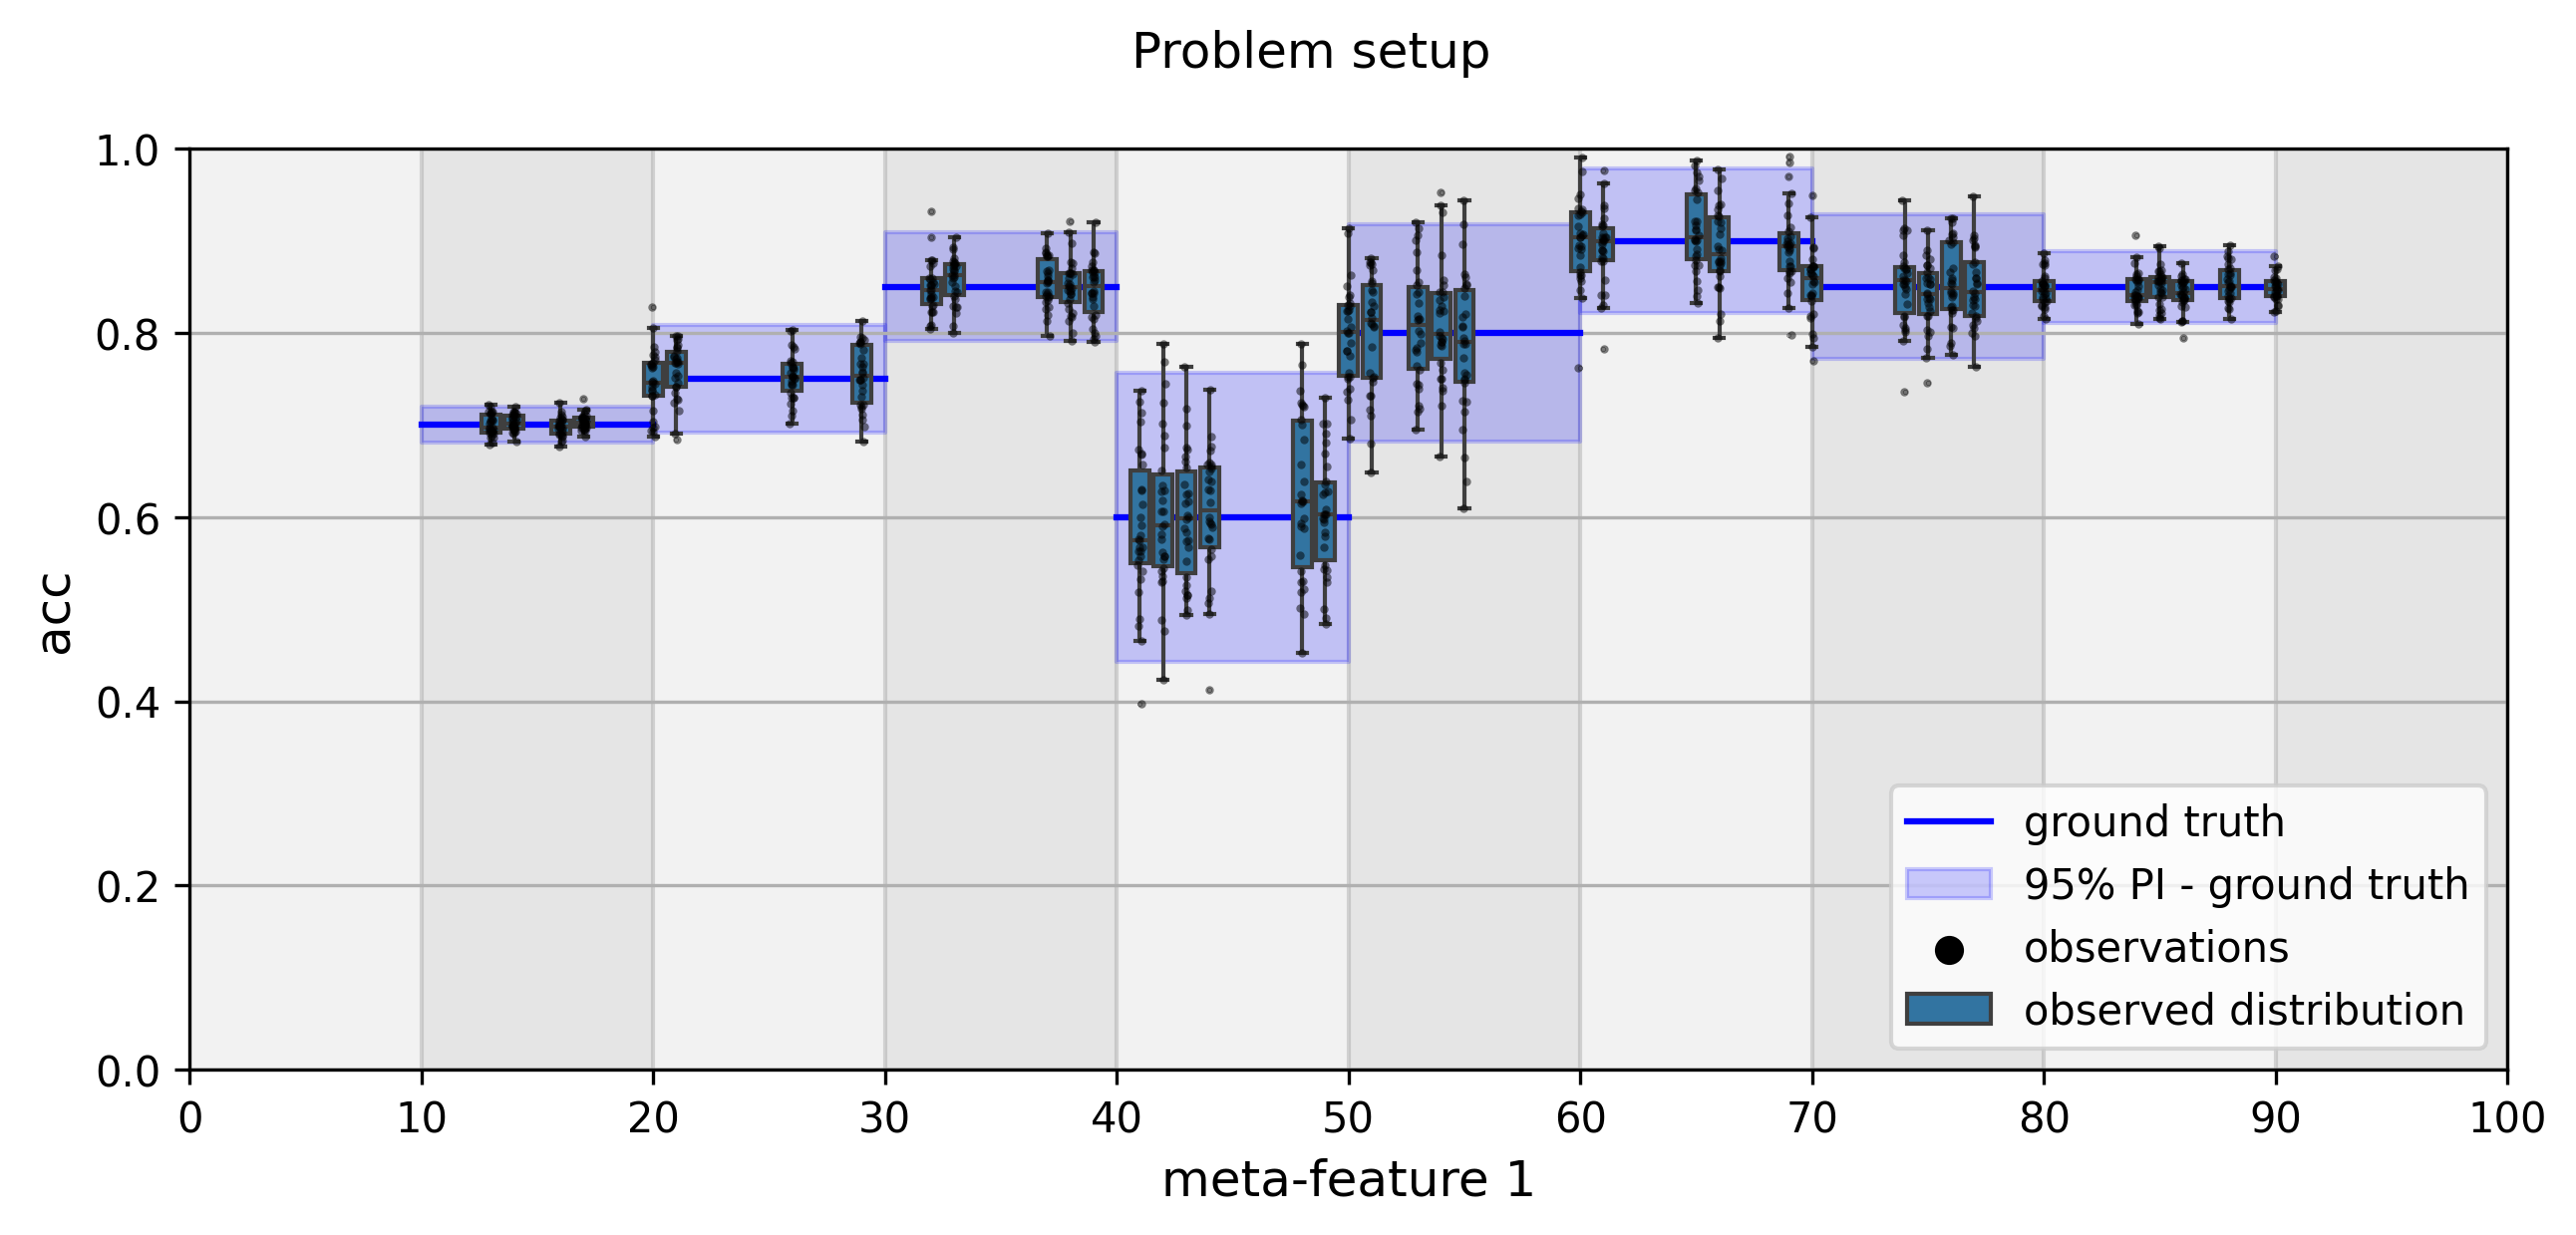

In [10]:
plot_data(x, y, x_agg, y_agg, x_test_qual)

### RF on aggregated mean and variance

In [11]:
#model and training
rf = RandomForestRegressor()
rf.fit(x_agg.reshape(-1,1), y_agg)

#predictions to calculate uncertainties
y_pred_mean_rf_help = np.empty([rf.n_estimators, x_test_qual.shape[0]])
y_pred_var_rf_help = np.empty([rf.n_estimators, x_test_qual.shape[0]])
for i in range(rf.n_estimators):
    y_pred_rf_help = rf.estimators_[i].predict(x_test_qual.reshape(-1,1))
    y_pred_mean_rf_help[i] = y_pred_rf_help[:,0]
    y_pred_var_rf_help[i] = y_pred_rf_help[:,1]

#mean prediction
y_pred_mean_rf = np.mean(y_pred_mean_rf_help, axis=0)

#uncertainties (var)
aleatoric_uncertainty_rf = np.mean(y_pred_var_rf_help, axis=0)
epistemic_uncertainty_rf = np.var(y_pred_mean_rf_help, axis=0)
total_uncertainty_rf = aleatoric_uncertainty_rf + epistemic_uncertainty_rf

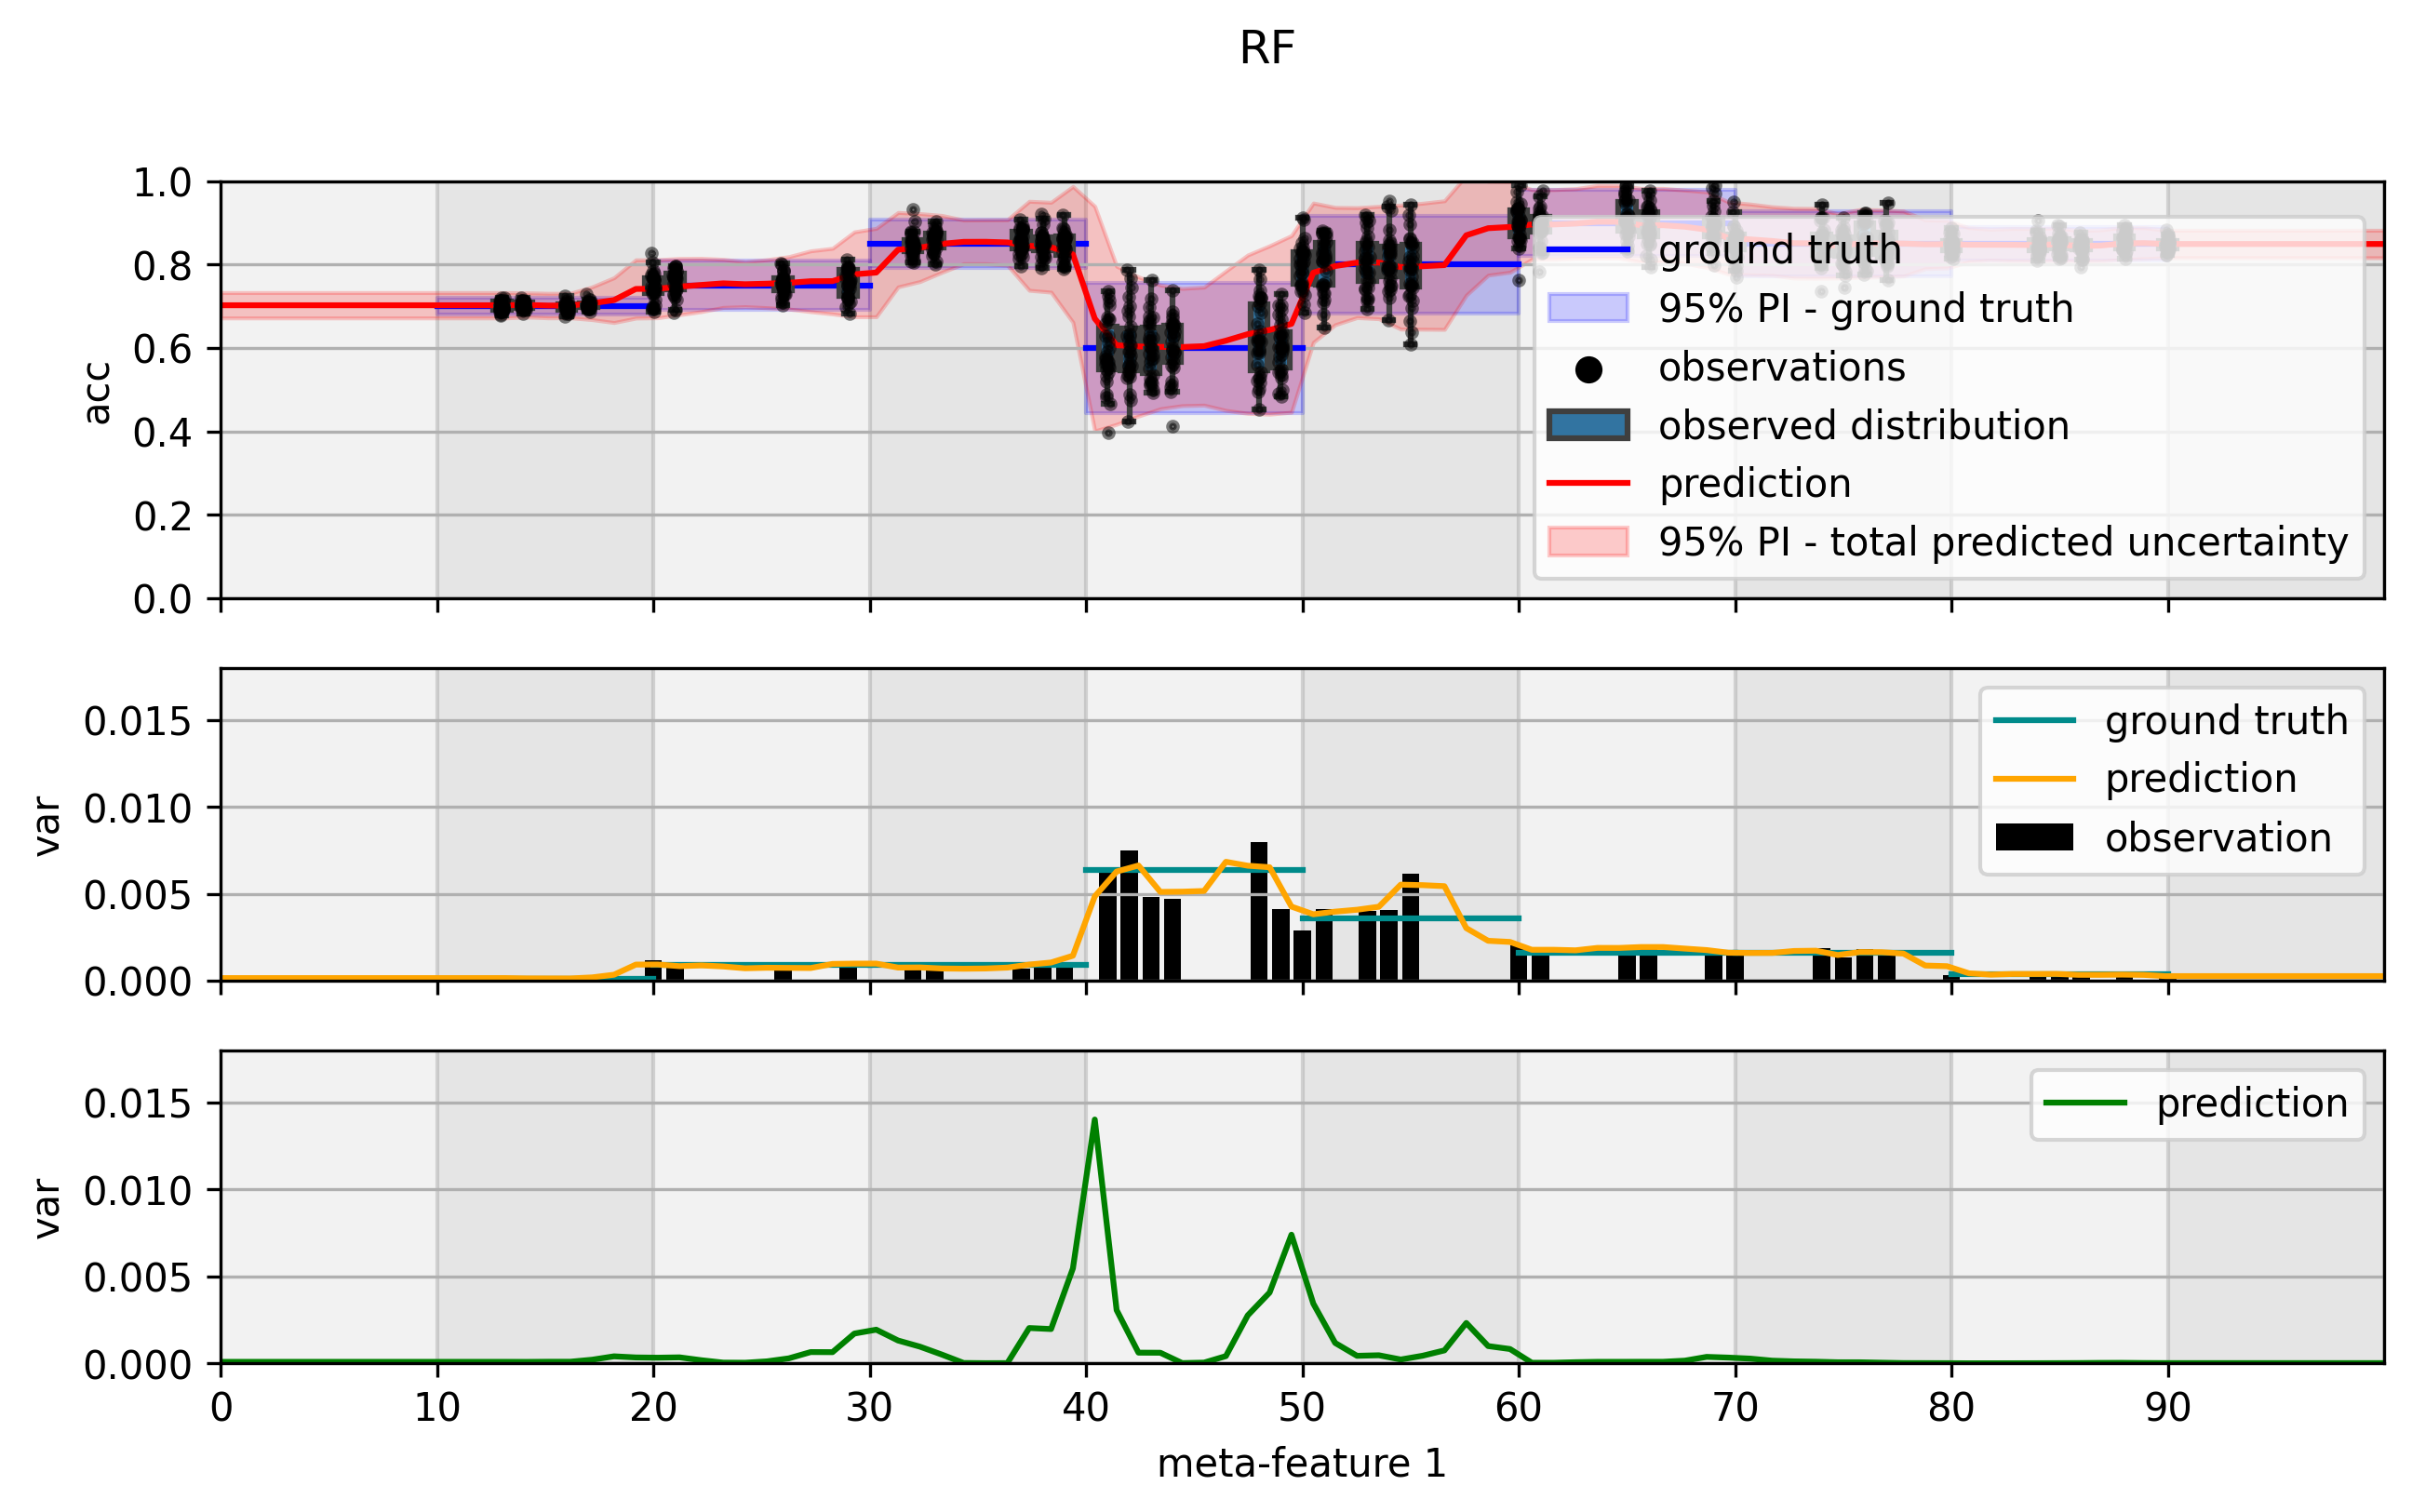

In [12]:
plot_data(x, y, x_agg, y_agg, x_test_qual, y_pred_mean_rf, aleatoric_uncertainty_rf, epistemic_uncertainty_rf, total_uncertainty_rf, title='RF')

### vSGLB

In [13]:
#model and training
cbr = CatBoostRegressor(loss_function='RMSEWithUncertainty', verbose=False,
                                        bootstrap_type='Bernoulli', custom_metric='RMSE',
                                        posterior_sampling=True, n_estimators=100, random_seed=i)
cbr.fit(x.reshape(-1,1), y)

#predictions to calculate uncertainties
pred_cbr_help = cbr.virtual_ensembles_predict(x_test_qual.reshape(-1,1), virtual_ensembles_count=10, prediction_type='TotalUncertainty')

#mean prediction
y_pred_mean_cbr = pred_cbr_help[:,0] 

#uncertainties
epistemic_uncertainty_cbr = pred_cbr_help[:,1]
aleatoric_uncertainty_cbr = pred_cbr_help[:,2]
total_uncertainty_cbr = epistemic_uncertainty_cbr + aleatoric_uncertainty_cbr

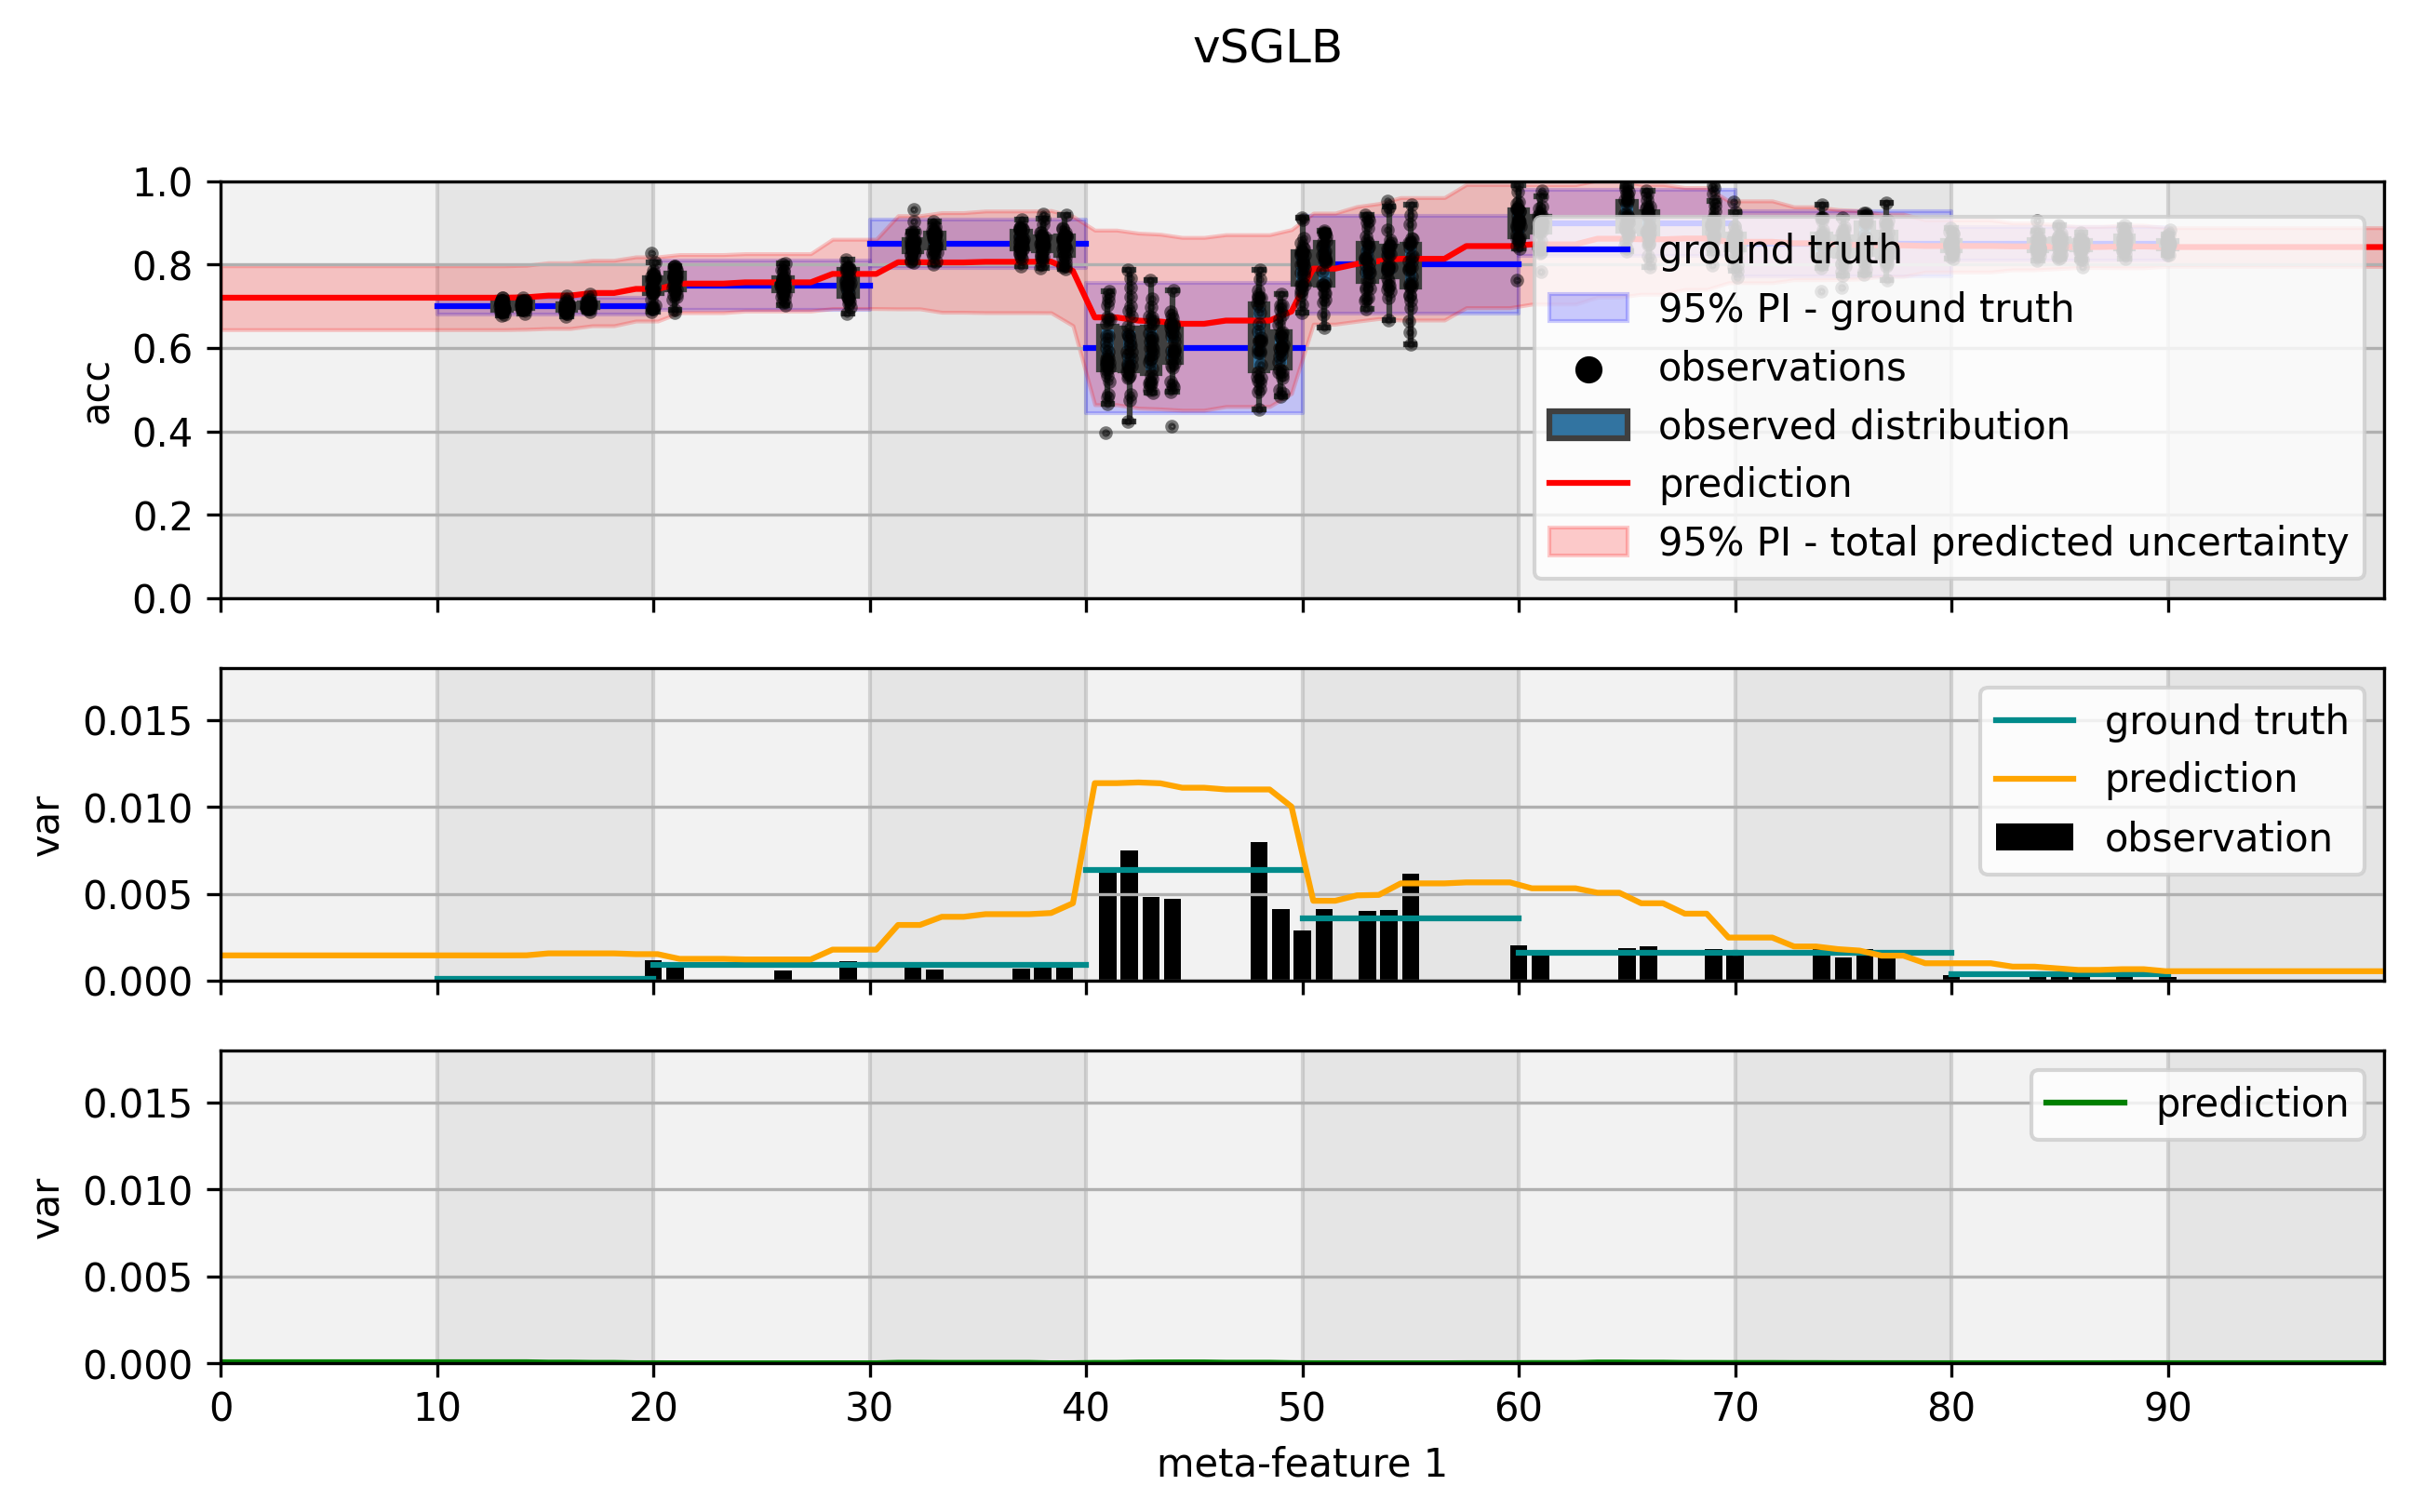

In [14]:
plot_data(x, y, x_agg, y_agg, x_test_qual, y_pred_mean_cbr, aleatoric_uncertainty_cbr, epistemic_uncertainty_cbr, total_uncertainty_cbr, title='vSGLB')

### GPR on aggregated mean and variance

In [15]:
#model and training
gpr_mean = GaussianProcessRegressor(Matern(), normalize_y=True, alpha=y_agg[:,1])
gpr_var = GaussianProcessRegressor()
gpr_mean.fit(x_agg.reshape(-1,1), y_agg[:,0])
gpr_var.fit(x_agg.reshape(-1,1), y_agg[:,1])

#predictions to calculate uncertainties
y_pred_mean_gpr, y_pred_epistemic_gpr = gpr_mean.predict(x_test_qual.reshape(-1,1), return_std=True)
y_pred_var_gpr = gpr_var.predict(x_test_qual.reshape(-1,1), return_std=False)

#mean prediction
y_pred_mean_gpr = y_pred_mean_gpr

#uncertainties
epistemic_uncertainty_gpr = y_pred_epistemic_gpr**2
aleatoric_uncertainty_gpr = y_pred_var_gpr
total_uncertainty_gpr = epistemic_uncertainty_gpr + aleatoric_uncertainty_gpr

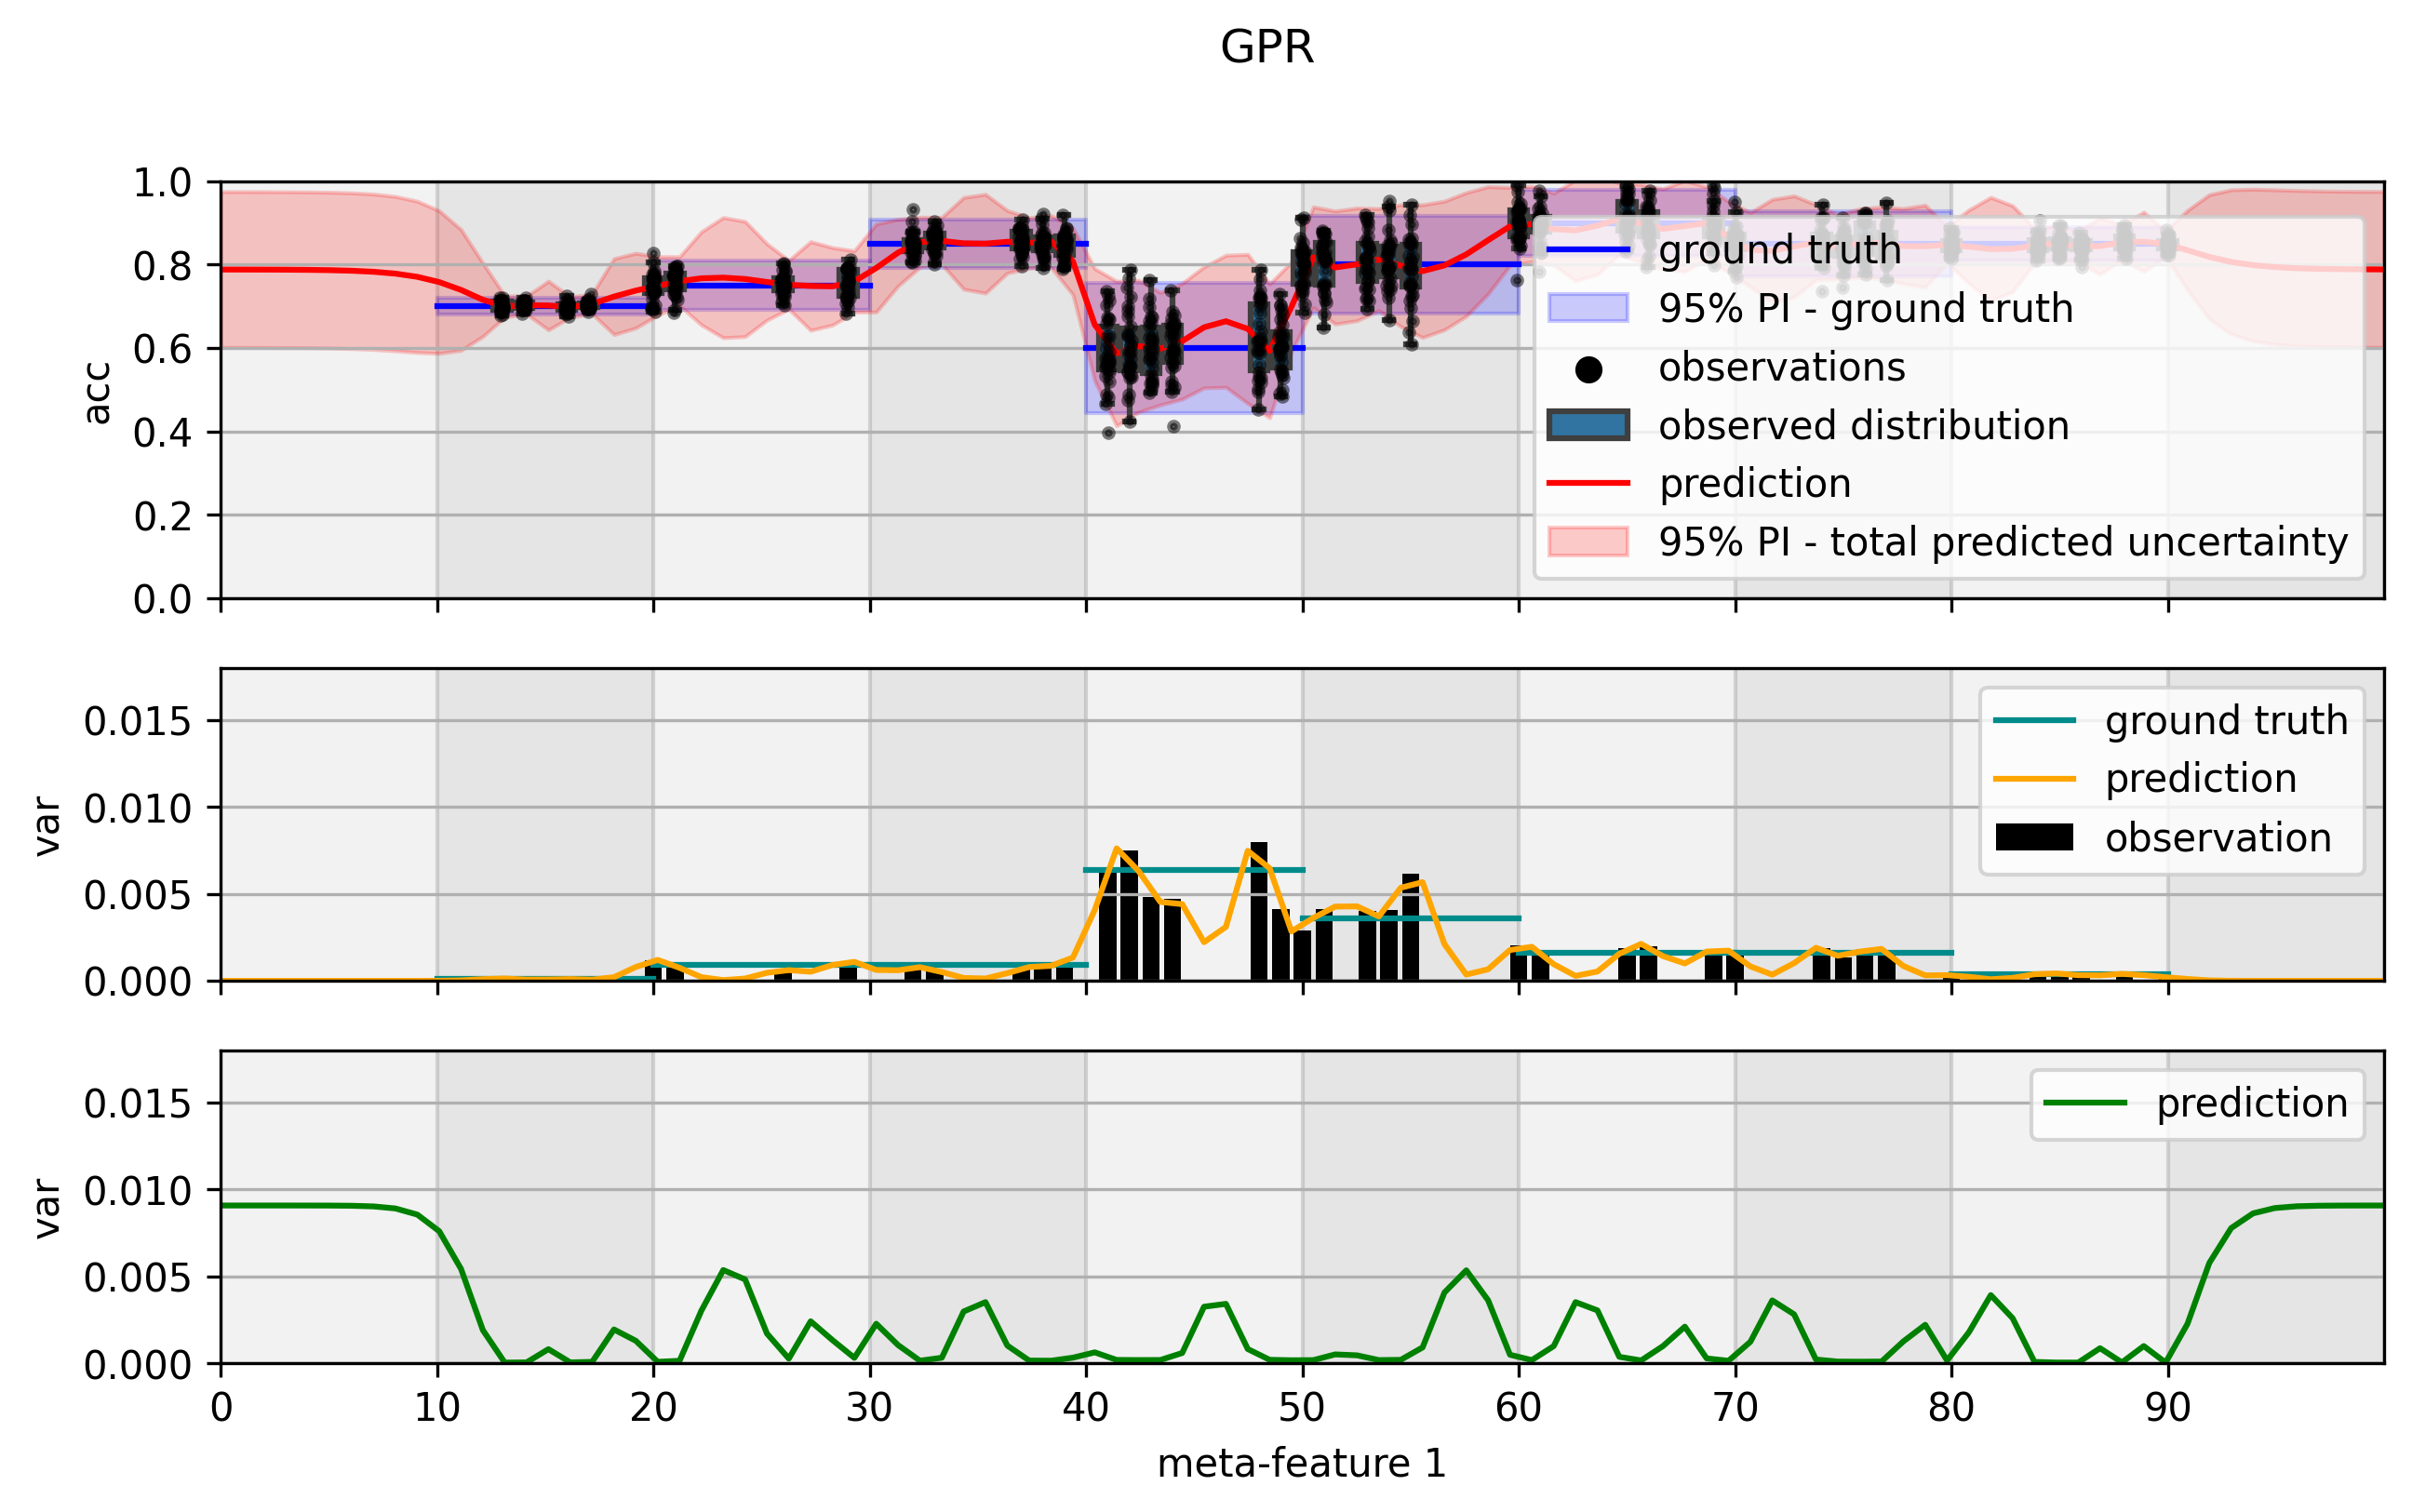

In [16]:
plot_data(x, y, x_agg, y_agg, x_test_qual, y_pred_mean_gpr, aleatoric_uncertainty_gpr, epistemic_uncertainty_gpr, total_uncertainty_gpr, title='GPR')

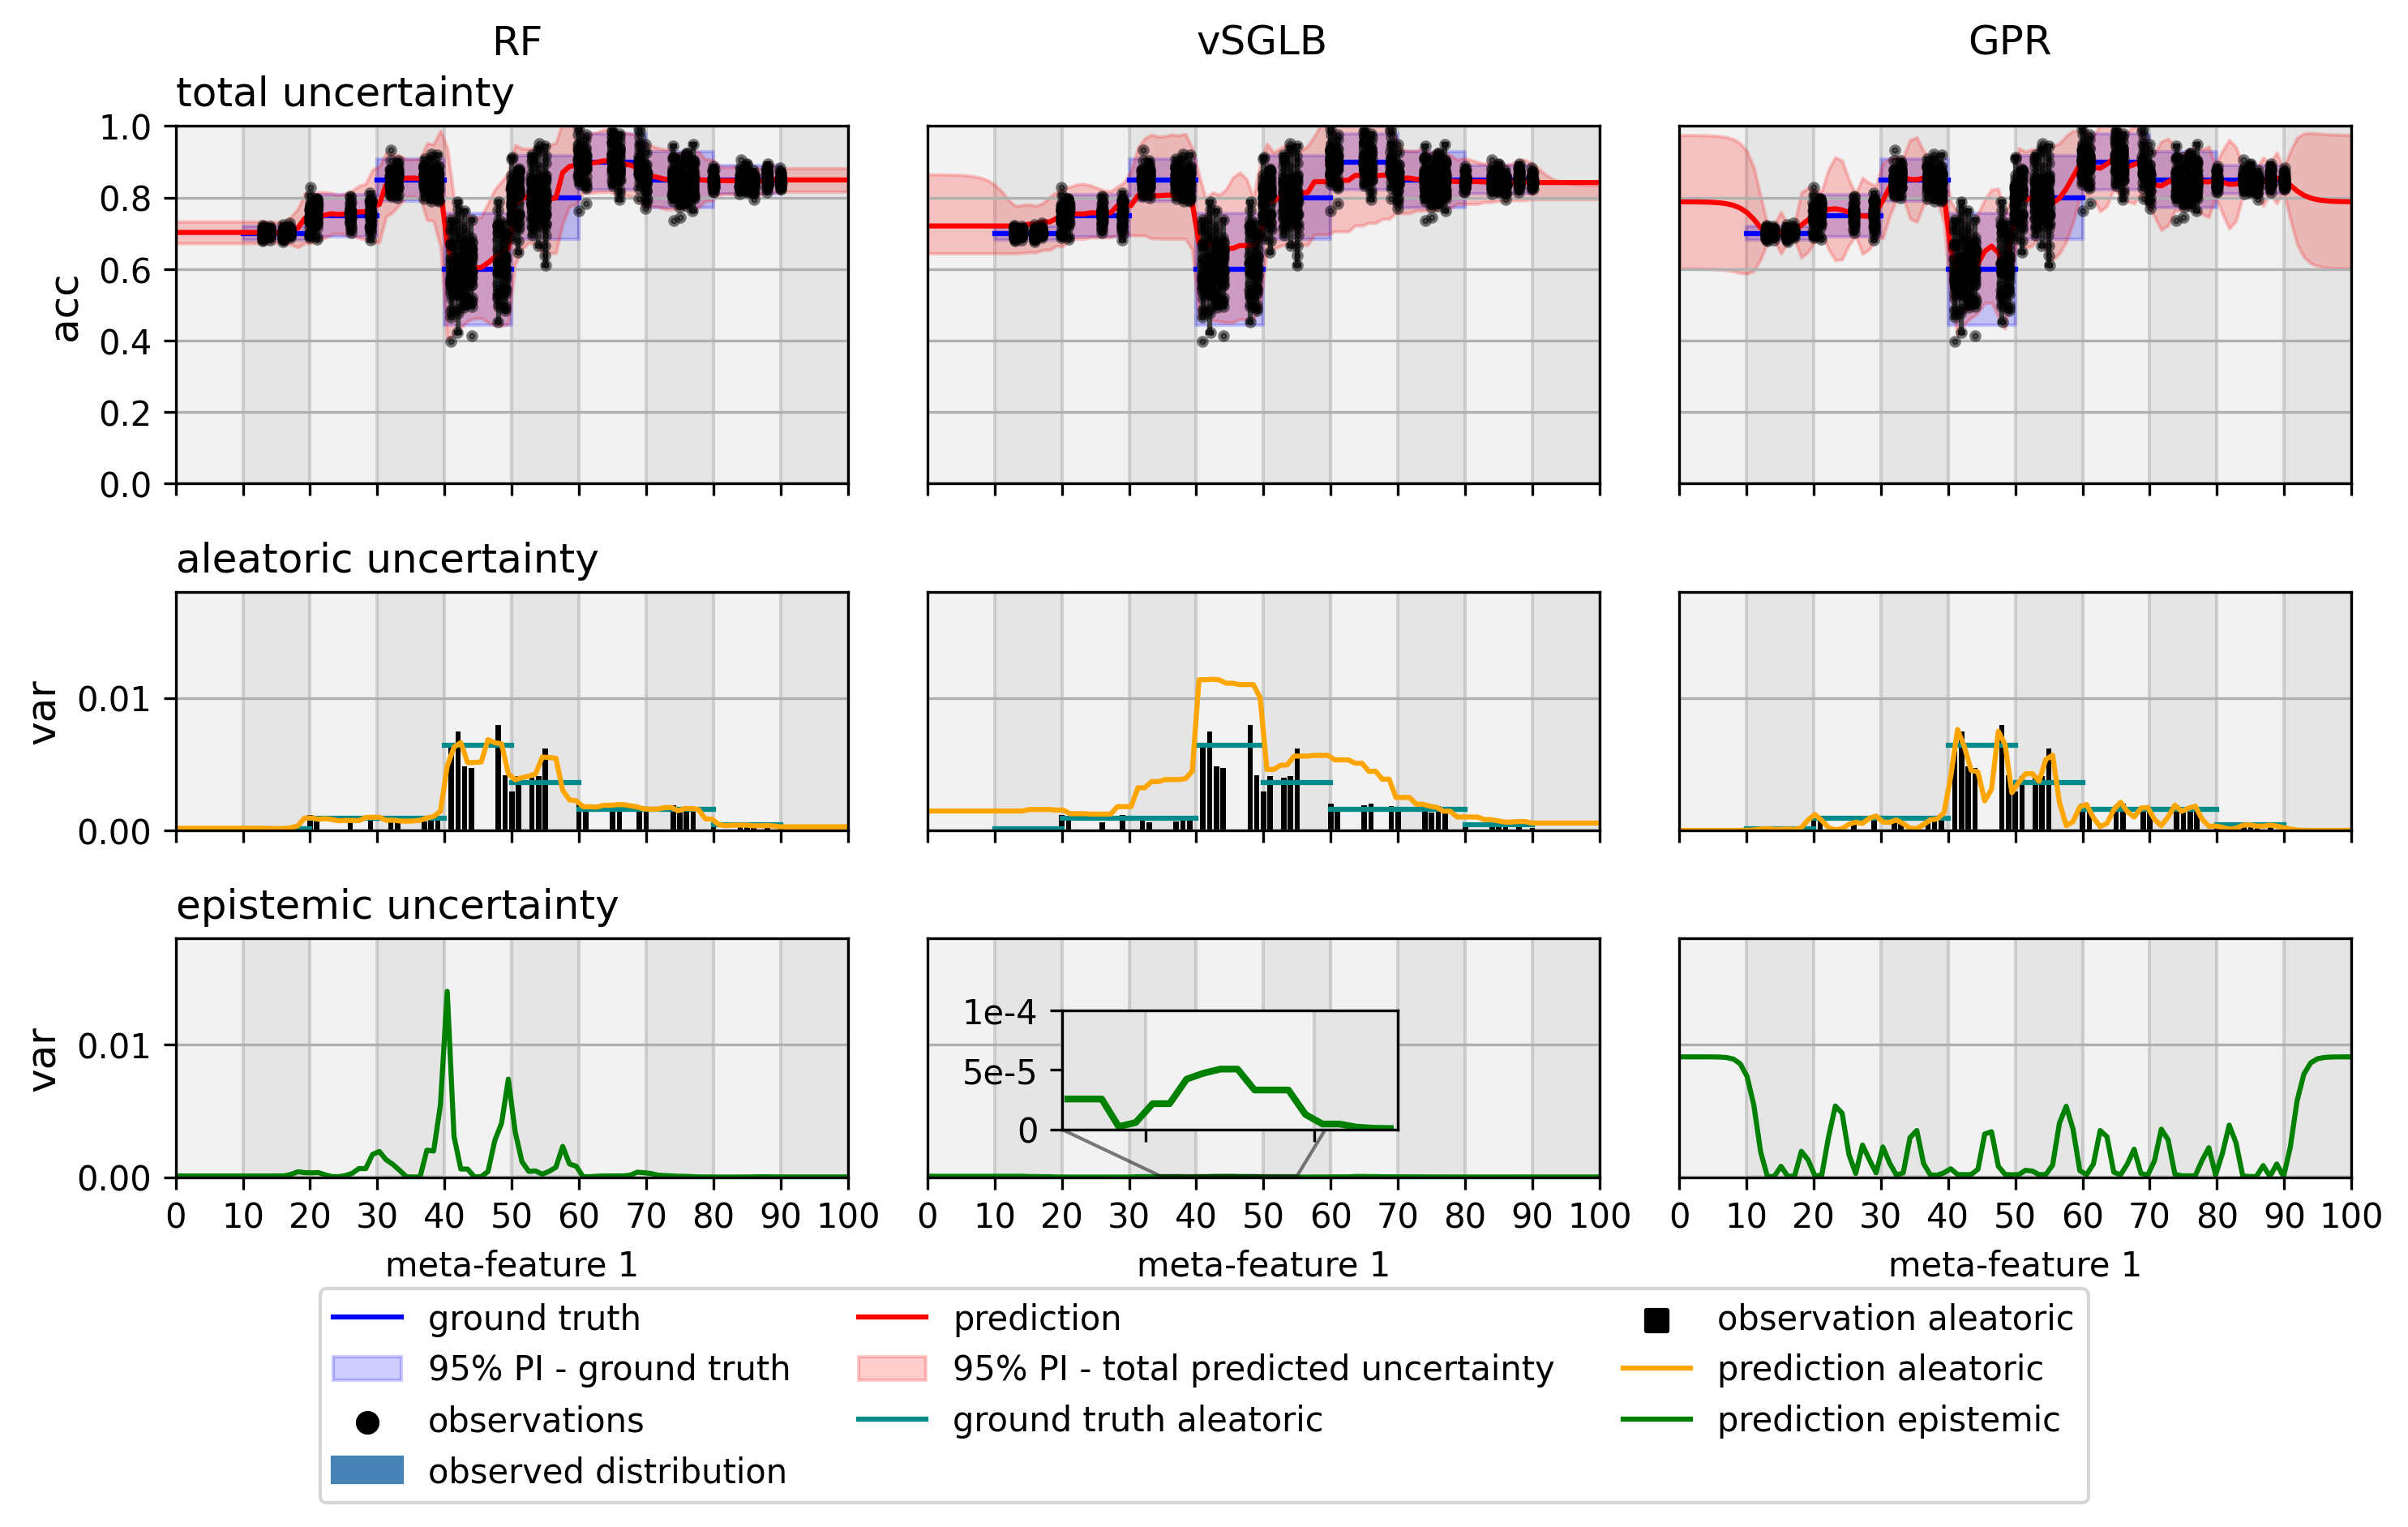

In [17]:
plot_all(x, y, x_agg, y_agg, x_test_qual,
         y_pred_mean_rf, aleatoric_uncertainty_rf, epistemic_uncertainty_rf, total_uncertainty_rf,
         y_pred_mean_cbr, aleatoric_uncertainty_cbr, epistemic_uncertainty_cbr, total_uncertainty_cbr, 
         y_pred_mean_gpr, aleatoric_uncertainty_gpr, epistemic_uncertainty_gpr, total_uncertainty_gpr)